Disclaimer: Artifical Intelligence was used throughout this code to assist in streamlining the building of larger chunk redundant chunks, to create performance improvements, and to help in the debugging process. This is original work with AI assistance.

#Preinitialization

In [1]:
#Preinitialization:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import graphviz
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve
)
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

!apt-get install graphviz
!pip install graphviz






data = pd.read_csv('coursework_data_20595117.csv')



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


#User Friendly Model Trained on Entire Data Set

##STEP 1: Load New Data

In [2]:
#Change the .csv to the new data csv file
data = pd.read_csv('coursework_data_20595117.csv')

Display first 5 lines of data & column names

In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,duration,campaign,pdays,previous,poutcome,y
0,45,blue-collar,married,primary,no,300,yes,no,cellular,29,203,1,261,3,failure,no
1,35,admin.,married,tertiary,no,163,yes,no,cellular,6,126,6,-1,0,unknown,no
2,29,blue-collar,married,primary,no,5,no,no,cellular,3,321,1,-1,0,unknown,yes
3,46,technician,married,secondary,no,488,no,no,unknown,5,92,1,-1,0,unknown,no
4,56,services,single,secondary,no,699,yes,no,cellular,20,193,1,-1,0,unknown,no


##STEP 2: Ensure column names are correctly referenced, and encode the variables that are categorical in nature

In [4]:
#STEP 2A: Define the data you wish to use (ensure column names match exactly)
X = data[['age', 'balance', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day',
         'campaign', 'pdays', 'previous', 'poutcome']].copy()
y = data['y']

#STEP 2B: Encode categorical variables
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
for feature in categorical_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])

##STEP 3: Run the model and choose training parameter

*   Set retrain = True if you wish to retrain the model on new data
*   Set retrain = False if you wish to use the previously trained model




Threshold: 0.50
Accuracy: 0.8237
Precision: 0.8622
Recall: 0.1995

Confusion Matrix:
[[3126   27]
 [ 678  169]]


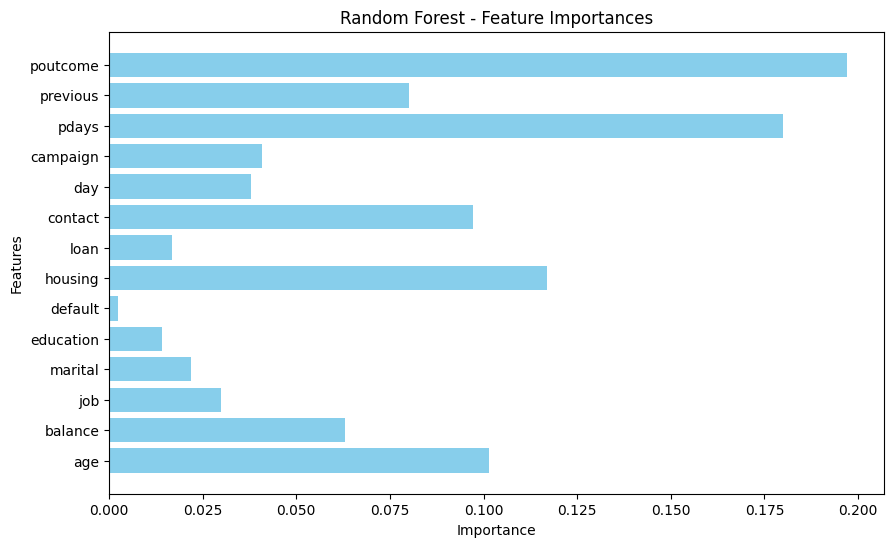


List of All True Positive Predictions:
      Customer #
47            47
53            53
115          115
164          164
186          186
...          ...
3949        3949
3950        3950
3953        3953
3962        3962
3974        3974

[169 rows x 1 columns]

New True Positives (with Threshold: 0.50):
      Customer #
513          513
520          520
1033        1033
2056        2056
2058        2058
...          ...
1010        1010
2548        2548
3065        3065
510          510
2047        2047

[169 rows x 1 columns]

Options:
1. 'yes' - Continue and lower the threshold by 0.05
2. 'export' - Export results to a CSV file (data of all customers to contact)
3. 'terminate' - Exit the loop


KeyboardInterrupt: Interrupted by user

In [5]:
# Encode target variable
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Add a 'Customer #' column for easier referencing in results (optional)
X.insert(0, 'Customer #', X.index)


# Function to train the Random Forest model
def train_model(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train.iloc[:, 1:], y_train)  # Exclude 'Customer #' column for training
    return model


# Function to evaluate the model with an adjustable threshold
def evaluate_model(model, X_eval, y_eval, threshold):
    # Make predictions and get probabilities
    y_pred_proba = model.predict_proba(X_eval.iloc[:, 1:])[:, 1]  # Exclude 'Customer #' column
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate metrics
    precision = precision_score(y_eval, y_pred)
    recall = recall_score(y_eval, y_pred)
    accuracy = accuracy_score(y_eval, y_pred)
    conf_matrix = confusion_matrix(y_eval, y_pred)

    # Display metrics
    print(f"Threshold: {threshold:.2f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Feature importance graph
    feature_importances = model.feature_importances_
    features = X_eval.columns[1:]  # Exclude 'Customer #' column
    plt.figure(figsize=(10, 6))
    plt.barh(features, feature_importances, color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Random Forest - Feature Importances')
    plt.show()

    # Get and display true positives
    true_positives = X_eval[(y_pred == 1) & (y_eval == 1)]

    print("\nList of All True Positive Predictions:")
    print(true_positives[['Customer #']])

    return true_positives


# Main loop for threshold adjustment and exporting results
#STEP 3: ADJUST RETRAIN ATTRIBUTE IF REQUIRED
def main_loop(threshold, X_train, y_train, X_new=None, y_new=None, retrain=True):
    global model
    if retrain or 'model' not in globals():
        model = train_model(X_train, y_train)

    # Evaluate on the current or new dataset
    X_eval = X_train if X_new is None else X_new
    y_eval = y_train if y_new is None else y_new

    all_true_positives = set()
    while True:
        true_positives = evaluate_model(model, X_eval, y_eval, threshold)

        # New true positives
        new_true_positives = set(true_positives.index) - all_true_positives
        print(f"\nNew True Positives (with Threshold: {threshold:.2f}):")
        print(true_positives.loc[list(new_true_positives), ['Customer #']])

        # Update record of all true positives
        all_true_positives.update(true_positives.index)

        # Display caution message if threshold is <= 0.3
        if threshold <= 0.3:
            print("\nCAUTION: Precision of the model is quite unreliable at such low threshold levels.")

        # Ask user if they want to continue
        print("\nOptions:")
        print("1. 'yes' - Continue and lower the threshold by 0.05")
        print("2. 'export' - Export results to a CSV file (data of all customers to contact)")
        print("3. 'terminate' - Exit the loop")
        response = input("Choose an option (yes/export/terminate): ").strip().lower()

        if response == 'yes':
            threshold -= 0.05
        elif response == 'export':
            filename = input("Enter the filename for the CSV (e.g., 'output.csv'): ").strip()
            all_customers = X_eval.loc[list(all_true_positives)].copy()
            all_customers.to_csv(filename, index=False)
            print(f"Data exported to {filename}")
        elif response == 'terminate':
            break
        else:
            print("Invalid option. Please choose 'yes', 'export', or 'terminate'.")

    print("Model iterations complete.")


# Example Usage
# Retrain the model and evaluate it on the original dataset
main_loop(threshold=0.5, X_train=X, y_train=y, retrain=True)

# Reuse the trained model to analyze a new dataset
# new_data = pd.read_csv('new_data.csv')
# Preprocess new_data as per the original steps
# main_loop(threshold=0.5, X_train=X, y_train=y, X_new=new_data, y_new=new_data['y'], retrain=False)

